In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

data_folder = Path("../../data")

# Necessary for notebook to see src package
import sys
sys.path.append('../..')

Device: cuda


# Download Dataset into Memory

In [4]:
dataset = pd.read_csv(data_folder / 'Adult' / 'data.csv')
dataset.head(10)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


# Missing Values

There is no missing values in CTABGAN+ datasets but i am just making sure

In [6]:
print(f'Missing values in the dataset: {dataset.isna().sum().sum()}')

Missing values in the dataset: 0


# General Info

- Column `education-num` had the same info as the `education` column so it was safe an beneficial to drop that column 
- We can see that the columns _workclass_, _education_, _marital-status_, _occupation_, _relationship_, _race_, _gender_, _native-country_, _income_ are categorical variables.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   gender          48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  income          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


In [11]:
string_columns = [col for col in dataset.columns if dataset[col].dtype == 'object']
other_columns = [col for col in dataset.columns if col not in string_columns]

print(f'String cols: {string_columns}')
print(f'Other cols: {other_columns}')

String cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
Other cols: ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# Other Columns and Their Cardinalities

In [12]:
for col in other_columns:
    print(f'{col:<20}: {dataset[col].dtype}({dataset[col].unique().__len__()})')

age                 : int64(74)
fnlwgt              : int64(28523)
capital-gain        : int64(123)
capital-loss        : int64(99)
hours-per-week      : int64(96)


# Single Mode Gaussian Variables 

Here we can see that `age` is a single mode Gaussion variable

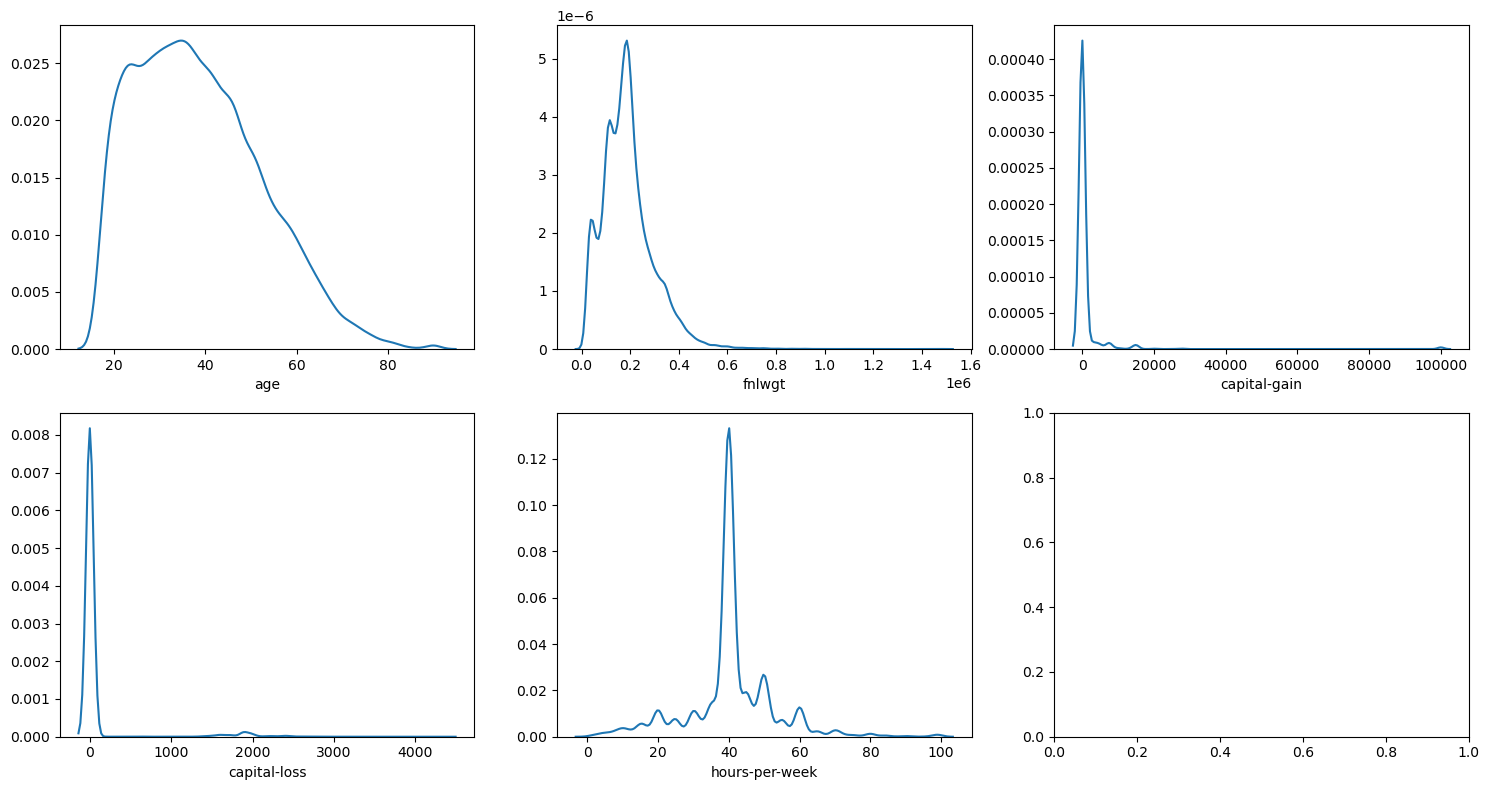

In [ ]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(other_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(other_columns) / 3.0), ncols=3)

for col_index in range(len(other_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.kdeplot(
        data=dataset[other_columns[col_index]],
        ax=current_ax,
        common_norm=False,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [56]:
from scipy.stats import shapiro, normaltest, anderson

print(f'{' ' * 20}  {"Shapiro Test":<20} {"Normal Test":<20} {"Anderson Test":<20}')

for col in other_columns:
    shapiro_stat, shapiro_p = shapiro(dataset[col])
    shapiro_string = f'{shapiro_stat:.2f}(p={shapiro_p:.2f})'
    dagostino_stat, dagostino_p = normaltest(dataset[col])
    dagostino_string = f'{dagostino_stat:.2f}(p={dagostino_p:.2f})'

    print(f'{col:<20}: {shapiro_string:<20} {dagostino_string:<20} {anderson(dataset[col]).statistic:<20}')

                      Shapiro Test         Normal Test          Anderson Test       
age                 : 0.97(p=0.00)         2297.74(p=0.00)      360.3991948894545   
fnlwgt              : 0.92(p=0.00)         15801.45(p=0.00)     573.8887708415714   
capital-gain        : 0.12(p=0.00)         82380.71(p=0.00)     15742.77388392113   
capital-loss        : 0.22(p=0.00)         43751.64(p=0.00)     17487.077430021192  
hours-per-week      : 0.88(p=0.00)         3839.25(p=0.00)      2658.0841591163626  


/tmp/ipykernel_106537/1586919671.py:6: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 48842.
  shapiro_stat, shapiro_p = shapiro(dataset[col])


# Mixed Type Variables

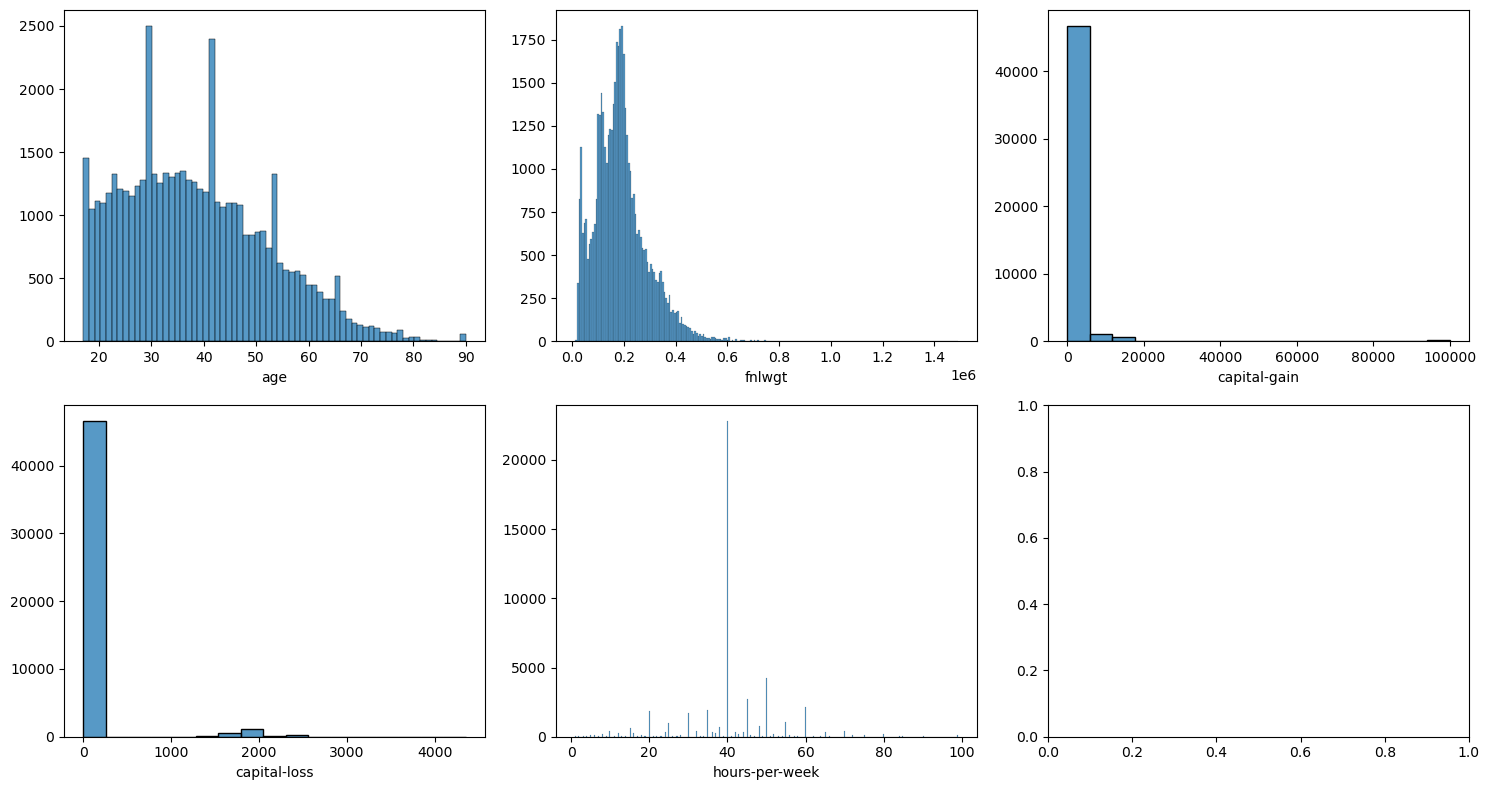

In [57]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(other_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(other_columns) / 3.0), ncols=3)

for col_index in range(len(other_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.histplot(
        data=dataset[other_columns[col_index]],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [58]:
dataset[['capital-loss', 'capital-gain']].mode()

,capital-loss,capital-gain
0,0,0


The final argumnets for the dataset is:

In [60]:
import json

args = {
    'categorical_columns' :string_columns,
    'log_columns': [],
    'mixed_columns': {'capital-loss':0.0, 'capital-gain':0.0}, # Mixed Type
    'general_columns': ['age'],                                 # Single Gaussian Mode or Highly cardinal data
    'non_categorical_columns': [],
    'integer_columns': [col for col in dataset.columns if (col not in string_columns) and (dataset[col].dtype=='int')],
    'problem_type': 'classification',
    'target': 'income'
}

with open(data_folder / 'Adult' / 'metadata.json', 'w+') as file:
    json.dump(args, file, indent=4)